<a href="https://colab.research.google.com/github/Ordo-Umbra/Void-Defect-Model/blob/main/defect_cascade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pair production triggered at tick 0, defect 0!
Pair production triggered at tick 0, defect 1!
Pair production triggered at tick 0, defect 2!
Pair production triggered at tick 0, defect 3!
Pair production triggered at tick 0, defect 4!
Pair production triggered at tick 0, defect 5!
Pair production triggered at tick 0, defect 6!
Pair production triggered at tick 0, defect 7!
Pair production triggered at tick 0, defect 8!
Pair production triggered at tick 0, defect 9!
Pair production triggered at tick 1, defect 6!
Pair production triggered at tick 1, defect 15!
Pair production triggered at tick 1, defect 16!
Pair production triggered at tick 1, defect 17!
Pair production triggered at tick 1, defect 18!
Pair production triggered at tick 1, defect 19!
Pair production triggered at tick 1, defect 20!
Pair production triggered at tick 1, defect 22!
Pair production triggered at tick 1, defect 23!
Pair production triggered at tick 1, defect 24!
Pair production triggered at tick 1, defect 25!
Pai

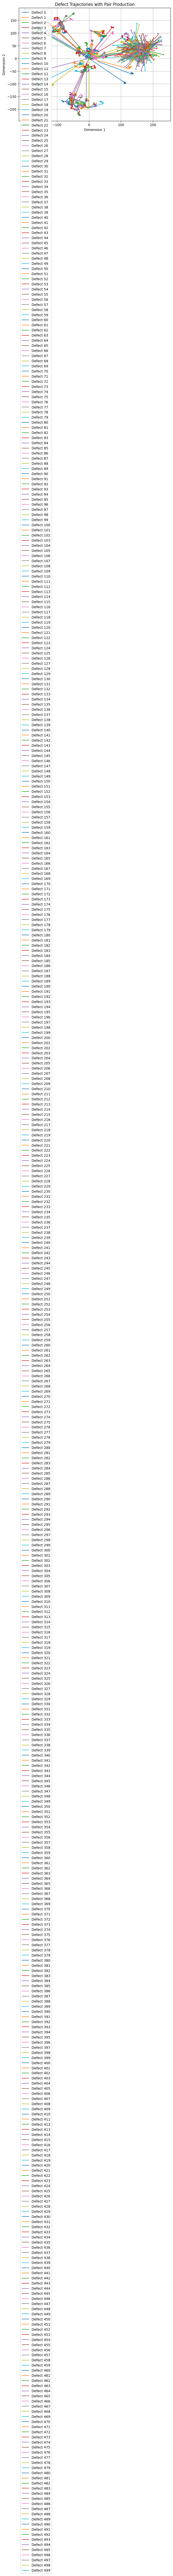

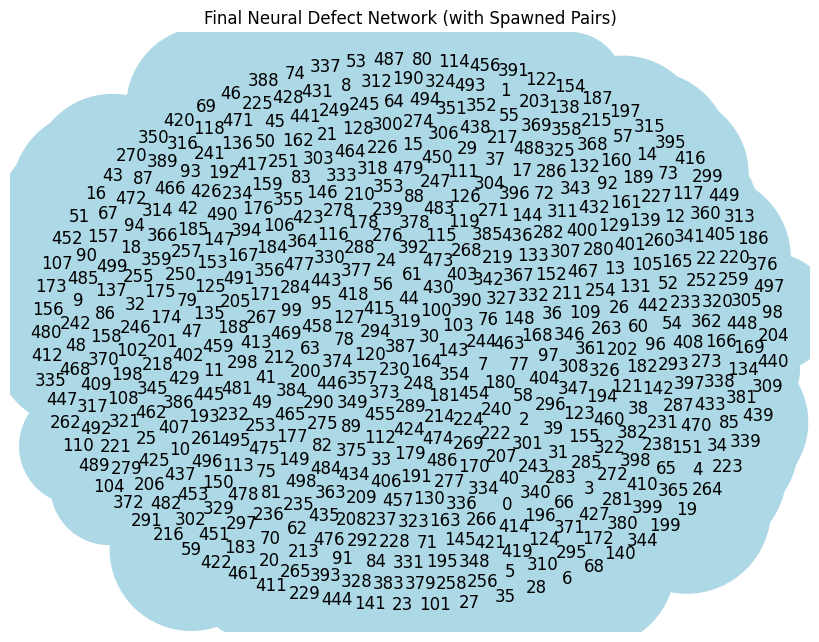

Cohesion achieved at steps: []
Final average I: 0.0020
Final energies (reinforcement): [32.835      33.33       32.64       32.82       32.73       33.075
 33.045      32.88       32.805      32.765      29.085      29.1
 29.07       29.055      28.98       29.01       29.07       29.145
 29.1        29.055      29.025      28.935      29.205      29.145
 29.145      29.025      28.92       28.965      29.135      29.185
 29.205      28.98       27.0825     27.1125     27.06       27.09
 27.1725     27.1875     27.09       27.09       27.0825     27.0825
 27.075      27.045      27.2025     27.2175     27.165      27.21
 27.135      27.15       27.195      27.06       27.0825     27.0825
 28.935      28.935      27.06       27.06       27.255      27.165
 26.09625    26.09625    26.22375    26.26875    26.1        26.1
 26.17125    26.20125    26.19       26.145      26.265      26.265
 26.1225     26.1225     26.1525     26.1225     27.1575     27.1725
 26.13375    26.16375    26.25  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Parameters (tuned for bound pair demo with user's explosion tweaks)
N_initial = 10  # Start with a quark-antiquark-like pair
steps = 2000  # Lowered for testing; increase with cap in place
dt = 1.0
sigma = 1.0  # Interaction range
damping = 0.8
chaos_lambda = 0.8  # Stochastic noise for instability
threshold_I = 0.5
alpha = 0.01  # Reinforcement rate
spawn_threshold = 1.0  # User's value for cascades
spawn_prob_base = 1.0  # User's value for higher trigger rate
max_N = 500  # New cap to prevent crashes; tune as needed
Phi_crit = 15.0  # For horizons; tune based on E spikes

# Initialize
rng = np.random.default_rng(42)
positions = rng.uniform(-1, 1, (N_initial, 2))  # Close initial pair
velocities = rng.uniform(-0.1, 0.1, (N_initial, 2))
E = np.ones(N_initial) * 5.0  # Higher initial E for deep binding
pos_history = [positions.copy()]  # List to handle dynamic N

def compute_grad_and_kernel(pos, sigma, E):
    diffs = pos[:, np.newaxis] - pos  # (N, N, 2)
    dists_sq = np.sum(diffs**2, axis=2)  # (N, N)
    kernel_matrix = np.exp(-dists_sq / (2 * sigma**2))  # (N, N)
    weighted_diffs = E[np.newaxis, :, np.newaxis] * kernel_matrix[:, :, np.newaxis] * diffs  # (N, N, 2)
    grad = -np.sum(weighted_diffs, axis=1) / sigma**2  # (N, 2)
    return grad, kernel_matrix

# Run
cohesion_steps = []
G = nx.Graph()
for i in range(N_initial):
    G.add_node(i)

positions_list = positions.copy()  # Dynamic array
velocities_list = velocities.copy()
E_list = E.copy()
N = N_initial

for t in range(steps):
    grad, kernel_matrix = compute_grad_and_kernel(positions_list, sigma, E_list)

    # Compute forces and distances
    force_mags = np.linalg.norm(grad, axis=1)
    dist_matrix = np.linalg.norm(positions_list[:, np.newaxis] - positions_list, axis=2)

    # Collect potential spawns first (no mid-loop changes)
    spawns = []
    for i in range(N):
        if force_mags[i] > spawn_threshold and rng.random() < spawn_prob_base * (force_mags[i] / spawn_threshold):
            print(f"Pair production triggered at tick {t}, defect {i}!")
            closest_j = np.argmin(dist_matrix[i] + 1e6 * (np.arange(N) == i))  # Exclude self
            mid_point = (positions_list[i] + positions_list[closest_j]) / 2
            new_pos1 = mid_point + rng.normal(0, 0.1, 2)  # Near mid, slight offset
            new_pos2 = mid_point + rng.normal(0, 0.1, 2)
            new_vel1 = rng.uniform(-0.1, 0.1, 2)
            new_vel2 = rng.uniform(-0.1, 0.1, 2)
            new_E = E_list[i] / 2
            spawns.append((i, closest_j, new_pos1, new_pos2, new_vel1, new_vel2, new_E, new_E))

    # Add all spawns at once, with max_N check
    for spawn in spawns:
        if N >= max_N:
            print(f"Max N {max_N} reached—skipping further spawns at tick {t}")
            break
        i, closest_j, p1, p2, v1, v2, e1, e2 = spawn
        positions_list = np.vstack([positions_list, p1, p2])
        velocities_list = np.vstack([velocities_list, v1, v2])
        E_list = np.append(E_list, [e1, e2])
        G.add_nodes_from([N, N+1])
        G.add_edge(i, N, weight=E_list[i] + e1)
        G.add_edge(closest_j, N+1, weight=E_list[closest_j] + e2)
        N += 2

    # Recompute grad and kernel for the full system (including new defects)
    if spawns:  # Only if spawns occurred
        grad, kernel_matrix = compute_grad_and_kernel(positions_list, sigma, E_list)

    # Horizon stalling and Hawking-like radiation
    Phi = np.sum(kernel_matrix * E_list[np.newaxis, :], axis=1)  # Superposition at r_i
    stall_factor = 0.1  # Soft stall; use 0.0 for hard freeze
    stall_mask = Phi > Phi_crit
    velocities_list[stall_mask] *= stall_factor

    # Hawking-like radiation near horizon
    horizon_mask = (Phi > 0.8 * Phi_crit) & (Phi < Phi_crit)  # Edge zone
    hawking_spawns = []
    for i in np.where(horizon_mask)[0]:
        if N >= max_N:
            print(f"Max N {max_N} reached—skipping Hawking spawns at tick {t}")
            break
        if rng.random() < 0.01 / Phi[i]:  # Prob inversely proportional to "size"
            print(f"Hawking-like pair at tick {t}, defect {i}!")
            core_dir = grad[i] / (np.linalg.norm(grad[i]) + 1e-8)  # Towards gradient
            escape_pos = positions_list[i] - 0.1 * core_dir  # Slight offset outward
            infall_pos = positions_list[i] + 0.1 * core_dir  # Inward
            new_vel_escape = rng.uniform(0.05, 0.1, 2) * -core_dir  # Outward push
            new_vel_infall = rng.uniform(0.05, 0.1, 2) * core_dir   # Inward
            new_E_rad = np.array([0.5, 0.5])  # Low energy radiation
            hawking_spawns.append((escape_pos, infall_pos, new_vel_escape, new_vel_infall, new_E_rad[0], new_E_rad[1]))

    # Add Hawking spawns
    for h_spawn in hawking_spawns:
        if N >= max_N:
            break
        p1, p2, v1, v2, e1, e2 = h_spawn
        positions_list = np.vstack([positions_list, p1, p2])
        velocities_list = np.vstack([velocities_list, v1, v2])
        E_list = np.append(E_list, [e1, e2])
        G.add_nodes_from([N, N+1])
        N += 2
        # Recompute grad/kernel post-Hawking for accuracy
        grad, kernel_matrix = compute_grad_and_kernel(positions_list, sigma, E_list)

    # Now update velocities and positions for all
    velocities_list = damping * velocities_list - dt * grad
    velocities_list += chaos_lambda * rng.normal(0, 0.05, velocities_list.shape)
    positions_list += dt * velocities_list
    pos_history.append(positions_list.copy())

    # Update interactions and reinforcement
    interact_mask = kernel_matrix > 0.5
    E_list += alpha * np.sum(interact_mask, axis=1)

    # Update graph
    G.clear_edges()
    for i in range(N):
        for j in range(i+1, N):
            if i < kernel_matrix.shape[0] and j < kernel_matrix.shape[0] and interact_mask[i, j]:
                G.add_edge(i, j, weight=E_list[i] + E_list[j])

    # Energy injection at mid-run (mimic collision)
    if t == steps // 2:
        print(f"Injecting energy at tick {t}: Separating pair.")
        velocities_list[0] += [0.5, 0.5]  # Push apart
        velocities_list[1] -= [0.5, 0.5]
        E_list *= 1.5  # Boost E

    # Cohesion check (recompute dist_matrix post-update)
    dist_matrix = np.linalg.norm(positions_list[:, np.newaxis] - positions_list, axis=2)
    I_avg = np.mean(np.exp(-dist_matrix**2 / sigma**2))
    if I_avg > threshold_I:
        cohesion_steps.append(t)

# Pad history to array (for varying N; use NaN for early ticks)
max_N_history = pos_history[-1].shape[0]
pos_history_array = np.full((len(pos_history), max_N_history, 2), np.nan)
for ti, p in enumerate(pos_history):
    pos_history_array[ti, :p.shape[0]] = p

plt.figure(figsize=(8, 6))
for i in range(max_N_history):
    valid = ~np.isnan(pos_history_array[:, i, 0])
    plt.plot(pos_history_array[valid, i, 0], pos_history_array[valid, i, 1], label=f'Defect {i}')
plt.title('Defect Trajectories with Pair Production')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
pos_graph = nx.spring_layout(G)
nx.draw(G, pos_graph, with_labels=True, node_size=500 * E_list, node_color='lightblue')
plt.title('Final Neural Defect Network (with Spawned Pairs)')
plt.show()

# Final I_avg recompute for print
dist_matrix = np.linalg.norm(positions_list[:, np.newaxis] - positions_list, axis=2)
I_avg = np.mean(np.exp(-dist_matrix**2 / sigma**2))

print(f"Cohesion achieved at steps: {cohesion_steps}")
print(f"Final average I: {I_avg:.4f}")
print(f"Final energies (reinforcement): {E_list}")